<a href="https://colab.research.google.com/github/MatteoRobbiati/notebooks/blob/main/QTI-hands-on-qibo/QTI_hands_on_qibo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#QTI TH - hands on qibo

### Download `qibo`

In [2]:
!pip install qibo
#!pip install qibojit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.8/225.8 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 KB 14.4 MB/s eta 0:00:00


### Getting started with qibo

Let's start importing `qibo` and the modules required for building our first circuit.
We set the default `numpy` backend for this tutorial.


In [3]:
# we import the qibo library
import qibo
from qibo import gates
from qibo.models import Circuit

import numpy as np
# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', font_scale=1.6)

# we use the numpy backend for doing simulation
qibo.set_backend('numpy')

[Qibo 0.1.10|INFO|2023-01-10 09:10:43]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


After this, we can start to do quantum circuit simulation using `qibo`.

## Some general feature

In [21]:
nqubits = 3
layers = 2

# initialize the circuit
c = Circuit(nqubits)

# adding some rotations 
for q in range(nqubits):
  c.add(gates.H(q))
  for l in range(layers):
    c.add(gates.RY(q=q, theta=0))
    c.add(gates.RZ(q=q, theta=0))
# adding a CNOT and a some measurements
c.add(gates.CNOT(q0=0, q1=nqubits-1))
c.add(gates.M(i) for i in range(nqubits))

In [22]:
print(c.draw())

q0: ─H─RY─RZ─RY─RZ─o─M─
q1: ─H─RY─RZ─RY─RZ─|─M─
q2: ─H─RY─RZ─RY─RZ─X─M─


In [24]:
# summary
print(c.summary())

Circuit depth = 7
Total number of gates = 19
Number of qubits = 3
Most common gates:
ry: 6
rz: 6
h: 3
measure: 3
cx: 1


In [25]:
# to Quantum Assembly Language
print(c.to_qasm())

// Generated by QIBO 0.1.10
OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg register0[1];
creg register1[1];
creg register2[1];
h q[0];
ry(0) q[0];
rz(0) q[0];
ry(0) q[0];
rz(0) q[0];
h q[1];
ry(0) q[1];
rz(0) q[1];
ry(0) q[1];
rz(0) q[1];
h q[2];
ry(0) q[2];
rz(0) q[2];
ry(0) q[2];
rz(0) q[2];
cx q[0],q[2];
measure q[0] -> register0[0];
measure q[1] -> register1[0];
measure q[2] -> register2[0];


In [31]:
# extracting information about parametetrized gates
first_parametrized_gate = c.parametrized_gates[0]

print("Gate object and memory address: ", first_parametrized_gate)
print("Gate name: ", first_parametrized_gate.name)
print("Number of variational parameters: ", first_parametrized_gate.nparams)

Gate object and memory address:  <qibo.gates.gates.RY object at 0x7f6040986970>
Gate name:  ry
Number of variational parameters:  1


In [32]:
# and their parameters
nparams = len(c.get_parameters())
print(nparams, c.get_parameters())

12 [(0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,)]


In [35]:
# inject a new set of parameters in the circuit

# generate the new set of params
test_params = np.random.randn(nparams)
# set them into the circuit
c.set_parameters(test_params)
# read circuit's parameters again
print(c.get_parameters())

[(-1.0074981396801996,), (0.3881878924046356,), (-1.692178938968129,), (2.3909008107358196,), (0.5862438245106449,), (-1.6940002983025253,), (0.5992752133023262,), (0.8436460944304217,), (0.6469779352584063,), (0.12741551716940375,), (-0.14676570612475143,), (-0.10224223897507545,)]


## State vector simulation

 
In quantum computing the state $| \psi \rangle $ of a system
of $n$ qubits is represented by a vector of $2^n$ complex probability amplitudes in the computational basis. 

Every action performed on a quantum state can be represented via matrix multiplication. In particular, if we consider a gate $G$ targeting $n_{tar}$ qubits, it might be represented as a $n_{tar} \times n_{tar}$ matrix.  This can be simulated adopting the **state vector simulation** approach. It solves:

$$ \psi'(\tau, q) = \sum_{\tau'} G(\tau, \tau')\psi(\tau', q), $$

where $\tau$ and $q$ denote bitstrings of length $n_{tar}$ and $n − n_{tar}$ respectively and the sum runs over
all possibile bitstrings $\tau$ of length $n_{tar}$. 

In [68]:
def visualize_states(counter):
 
  fig, ax = plt.subplots()

  ax.set_title('State visualization')
  ax.set_xlabel('States')
  ax.set_ylabel('#')

  for state in counter:
    ax.scatter(state, counter[state], color='purple', alpha=0.5, s=150)
    ax.vlines(state, 0, counter[state] - 12, color='black', ls='-', lw=1.2)


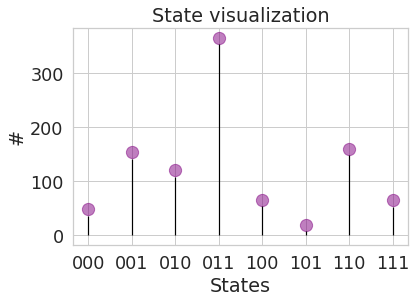

In [69]:
frequencies = c(nshots=1000).frequencies(binary=True)

visualize_states(frequencies)


### Simulating the superposition

Now we can build up a simple circuit composed of one qubit and an Hadamard gate. This gate is such that, if applied to one of the fundamental states, it returns a superposed state:

$$ H|0\rangle  = \frac{1}{\sqrt{2}}\bigl(|0\rangle + |1\rangle \bigr). $$
$$ H|1\rangle  = \frac{1}{\sqrt{2}}\bigl(|0\rangle - |1\rangle \bigr). $$

At the end of the circuit we put a measurement gate, in order to be able to project the final state on the $z$ direction and to perform a simple measurement operation.

Using a circuit diagram:

<center><img src="https://github.com/MatteoRobbiati/notebooks/blob/main/QTI-hands-on-qibo/figures/superposition.png?raw=true" alt="drawing" width="300"/></center>

In [48]:
# set the number of qubits of the circuit
nqubits = 1

In [72]:
# initialize the circuit 
c_1q = Circuit(nqubits=nqubits)

# if initial_state is not provided, default is |0>

# add gates
# an Hadamard gate and a measurement
c_1q.add(gates.H(q=0))
c_1q.add(gates.M(0))

# draw circuit
print("Circuit's object: ", c_1q)
print(c_1q.draw())

Circuit's object:  <qibo.models.circuit.Circuit object at 0x7f603fe6e460>
q0: ─H─M─
q1: ─────


### Simulating the execution of the circuit

Now we can execute the circuit $N_{shots}=1000$ times, and use the simulation tool for getting the results.


In [51]:
# executing nshot times the circuit we get the simulated final state
simulated_final_state = c_1q(nshots=1000)

print(simulated_final_state)

(0.70711+0j)|0> + (0.70711+0j)|1>


With this execution we simulate the final state obtained applying an Hadamard gate on an initial $| 0 \rangle$ state.

#### Printing frequencies

Now we can use the `frequencies` method for visualizing the obtained results. One way to do that is to activate the `binary=False` option; thanks to this we get a counter object which shows us how many times the two fundamental states are registered after one thousand of executions.


In [52]:
freq = simulated_final_state.frequencies(binary=True)
print(freq)

Counter({'1': 522, '0': 478})


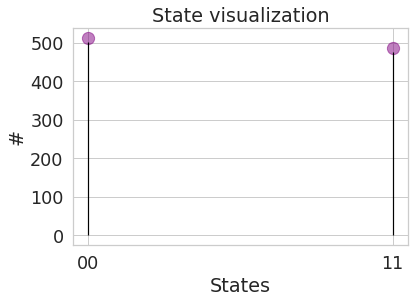

In [70]:
visualize_states(freq)


#### Printing probabilities

Alternatively, we can use the `probabilities` method.

In [54]:
# calculating probabilities
probabilities = simulated_final_state.probabilities

# showing the two probabilities
print(probabilities(qubits=[0]))

[0.5 0.5]



As expected, the probability of obtaining each of the two fundamental states is equal to 0.5.

you can repeat this experiment many times, but you will always get these probabilities as results. 

In [55]:
# let's try to repeat the experiment 10 times
for _ in range(10):
    simulated_final_state = c_1q(nshots=100)
    probabilities = simulated_final_state.probabilities
    print(probabilities(qubits=[0]))

[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]


This is good, because we are dealing with a simulation and, in this particular case, we are simulating perfect measurements. There is a way in `qibo` to make the measurement more realistic. To verify this, we need to define the circuit again and this time we will enable the `collapse=True` option inside the port representing the measurement.


### Measurements in qibo

In qibo we provide two different ways for performing measurements:

- **without collapse**: the quantum state is simulated, then we sample the measurements output using a random generator starting by the quantum state, without making him collapse.
- **with collapse**: the state vector collapse into one of the accessible states following the theoretical probabilies.

In [56]:
# initialize a new realistic circuit
c_real = Circuit(1)

# add gates
c_real.add(gates.H(q=0))
c_real.add(gates.M(0, collapse=True))

results = c_real(nshots=5)
results

[array([1.+0.j, 0.+0.j]),
 array([1.+0.j, 0.+0.j]),
 array([0.+0.j, 1.+0.j]),
 array([0.+0.j, 1.+0.j]),
 array([0.+0.j, 1.+0.j])]

Each measurement here returns an array object in $C^2$ containing the measured (collapsed) state.

## Quantum simulation is exact

This procedure provide us with a list of collapsed vectors. If we want to verify the difference between this method and the previous one, we need to perform five times the collapsing of one thousand states.


In [57]:
for experiment in range(10):
    prob = 0
    for shot in range(100):
        # summing the real part of the first component of the final quantum state
        prob += np.real(c_real()[0][0])
    prob /= 100
    print(prob)

0.58
0.52
0.5
0.48
0.58
0.51
0.55
0.52
0.57
0.49


As we can see, in this case we get different values of probabilities, in accordance with the fluctuations that are recorded on real quantum devices.


## Building entanglement

Let's consider now a two qubit system. We can use two-qubits gates for building entanglement. This means that the total final state of the system is such that the output obtained measuring qubit 1 affects the result on the qubit 2. For building an entangled Bell's state we can use for example an Hadmard gate and a c-NOT gate.

Using a circuit diagram, we are going to do the following:
<center><img src="https://github.com/MatteoRobbiati/notebooks/blob/main/QTI-hands-on-qibo/figures/entanglement.png?raw=true" alt="drawing" width="400"/></center>

In [58]:
nqubits = 2

# new circuit
c_ent = Circuit(nqubits)

# H and than a c-NOT gate
c_ent.add(gates.H(q=0))
c_ent.add(gates.CNOT(q0=0, q1=1))
c_ent.add(gates.M(0,1))

MeasurementResult(qubits=(0, 1), nshots=0)

In [59]:
final_state_ent = c_ent(nshots=1000)
print(final_state_ent)

(0.70711+0j)|00> + (0.70711+0j)|11>


In [60]:
freq = final_state_ent.frequencies(binary=True)

freq

Counter({'00': 513, '11': 487})

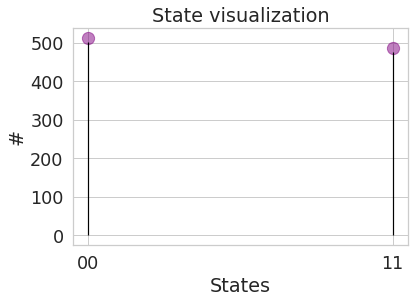

In [71]:
visualize_states(freq)

## How can we build the others Bell's state?